# 🧠 Sistema Endocrino Simulado para LLMs
### TFM: Simulación endocrina aplicada a LLMs
**Estudiante:** Nicola Korff  
**Tutor:** Matías Nuñez  
**Modelo base:** DistilGPT-2

---

## 📋 Estructura del Notebook
1. Setup y dependencias
2. Carga del modelo base
3. Vector hormonal y transformaciones de logits
4. Generación baseline
5. Experimentos con perfiles hormonales
6. Evaluación básica
7. Visualización de resultados


## 1. Setup y Dependencias

In [ ]:
# Instalación de dependencias
!pip install -q transformers torch datasets nltk textblob numpy pandas matplotlib seaborn tqdm
!pip install -q sacrebleu rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, LogitsProcessor, LogitsProcessorList, NoRepeatNGramLogitsProcessor, pipeline
from typing import List, Dict, Tuple
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📍 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


📍 Using device: cuda
   GPU: NVIDIA A100-SXM4-40GB
   Memory: 39.6 GB


## 2. Carga del Modelo Base (DistilGPT-2)

utilizamos como modelo base un transformador autoregresivo de la familia GPT-2, en una variante de tamaño medio, por tres razones principales: es un modelo ampliamente utilizado y de pesos abiertos, lo que facilita la reproducibilidad; tiene una arquitectura compatible con la interfaz estándar de transformers (AutoModelForCausalLM), que nos permite acceder directamente a los logits y aplicar procesadores personalizados como el sistema endocrino simulado; y su tamaño moderado hace posible ejecutar todos los experimentos en entornos accesibles, como Google Colab o incluso CPU, sin requerir hardware especializado. Dado que el objetivo central del trabajo no es maximizar la calidad literaria absoluta del texto, sino estudiar de forma controlada cómo la modulación “hormonal” afecta a la distribución de probabilidad y a las métricas de generación, un modelo de esta escala como base.

In [ ]:
# Modelo y tokenizer
MODEL_NAME = "gpt2-medium"  # Alternativas: "gpt2", "gpt2-medium"

print(f"🔄 Loading {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

# Configuración del tokenizer
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

print(f"✅ Model loaded successfully")
print(f"   Parameters: {model.num_parameters() / 1e6:.1f}M")
print(f"   Vocabulary size: {len(tokenizer)}")

🔄 Loading gpt2-medium...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✅ Model loaded successfully
   Parameters: 354.8M
   Vocabulary size: 50257


## 3. Vector Hormonal y Sistema Endocrino

### Definición del Vector Hormonal H = [d, c, o, a, s]
- **d (dopamina)**: exploración y recompensa → ↑ temperatura
- **c (cortisol)**: cautela y precisión → ↓ temperatura
- **o (oxitocina)**: prosocialidad → sesgo hacia tokens empáticos
- **a (adrenalina)**: activación → modula el enfoque (visión de túnel)
- **s (serotonina)**: estabilidad → amortigua extremos y repetición

En este notebook tratamos cada hormona como un **control deslizante entre 0 y 1** que ajusta el comportamiento del modelo:

- La **dopamina alta** aumenta la temperatura efectiva y favorece la exploración: el modelo se anima a probar continuaciones menos probables.
- El **cortisol alto** hace lo contrario: baja la temperatura, haciendo que el modelo se centre en las opciones más probables; si es demasiado alto, puede llevar a repeticiones o textos muy rígidos, por eso lo combinaremos con mecanismos anti-repetición.
- La **oxitocina alta** no toca la temperatura, sino que introduce un **sesgo suave** hacia palabras empáticas (por ejemplo, *understand, help, support*), de forma que el modelo tienda a formular respuestas más cuidadoras sin imponer un guion fijo.
- La **adrenalina alta** la usaremos como un control de **enfoque atencional** mediante un Top-K dinámico, reduciendo el vocabulario disponible cuando el sistema está “hiperactivado”.
- La **serotonina alta** representa estabilidad: en lugar de ser otra temperatura disfrazada, se implementa como un **suavizado de los extremos** de los logits, reduciendo la varianza de la distribución y dificultando que el modelo se vaya a soluciones demasiado extremas o caóticas.

La idea general es que el vector hormonal **no sustituye** a los hiperparámetros clásicos de generación, sino que los organiza de forma más interpretable: cada combinación de valores define un “perfil psicológico” reproducible que luego podremos analizar con métricas cuantitativas.


In [ ]:
@dataclass
class HormonalVector:
    """Vector hormonal H = [d, c, o, a, s]"""
    dopamine: float = 0.5      # d: exploración
    cortisol: float = 0.5      # c: cautela
    oxytocin: float = 0.5      # o: prosocialidad
    adrenaline: float = 0.5    # a: activación
    serotonin: float = 0.5     # s: estabilidad

    def __repr__(self):
        return f"H[d={self.dopamine:.2f}, c={self.cortisol:.2f}, o={self.oxytocin:.2f}, a={self.adrenaline:.2f}, s={self.serotonin:.2f}]"

    def to_dict(self):
        return {
            'dopamine': self.dopamine,
            'cortisol': self.cortisol,
            'oxytocin': self.oxytocin,
            'adrenaline': self.adrenaline,
            'serotonin': self.serotonin
        }

# Perfiles hormonales predefinidos
PROFILES = {
    "baseline": HormonalVector(0.5, 0.5, 0.5, 0.5, 0.5),
    "euphoric": HormonalVector(dopamine=0.9, serotonin=0.8, cortisol=0.2, adrenaline=0.5, oxytocin=0.5),
    "stressed": HormonalVector(cortisol=0.9, adrenaline=0.7, serotonin=0.3, dopamine=0.5, oxytocin=0.5),
    "empathetic": HormonalVector(oxytocin=0.9, serotonin=0.7, dopamine=0.6, cortisol=0.5, adrenaline=0.5),
    "cautious": HormonalVector(cortisol=0.7, dopamine=0.3, serotonin=0.6, adrenaline=0.5, oxytocin=0.5),
    "high_dopamine": HormonalVector(dopamine=0.9, cortisol=0.5, oxytocin=0.5, adrenaline=0.5, serotonin=0.5),
    "high_serotonin": HormonalVector(serotonin=0.9, dopamine=0.5, cortisol=0.5, adrenaline=0.5, oxytocin=0.5),
}

print("📊 Perfiles hormonales disponibles:")
for name, profile in PROFILES.items():
    print(f"  - {name}: {profile}")

📊 Perfiles hormonales disponibles:
  - baseline: H[d=0.50, c=0.50, o=0.50, a=0.50, s=0.50]
  - euphoric: H[d=0.90, c=0.20, o=0.50, a=0.50, s=0.80]
  - stressed: H[d=0.50, c=0.90, o=0.50, a=0.70, s=0.30]
  - empathetic: H[d=0.60, c=0.50, o=0.90, a=0.50, s=0.70]
  - cautious: H[d=0.30, c=0.70, o=0.50, a=0.50, s=0.60]
  - high_dopamine: H[d=0.90, c=0.50, o=0.50, a=0.50, s=0.50]
  - high_serotonin: H[d=0.50, c=0.50, o=0.50, a=0.50, s=0.90]


### 3.1 Interpretación matemática de la modulación hormonal

En esta parte del notebook definimos la pieza clave del sistema endocrino simulado: la clase `HormonalLogitsProcessor`. Su función es intervenir **justo antes** de que el modelo decida la siguiente palabra.

El modelo de lenguaje, internamente, no piensa en palabras sino en una lista de números llamada **logits**. Podemos imaginarlos como una fila de “puntuaciones” $(s_1, s_2, \dots, s_V)$, una para cada posible token del vocabulario (donde (V) es el tamaño del vocabulario). Cuanto más grande es un logit, más probable será que el modelo elija ese token cuando convierta estas puntuaciones en probabilidades mediante la función Softmax.

Nuestro “sistema hormonal” actúa sobre esa fila de puntuaciones antes de que se conviertan en probabilidades. Así, cada hormona ajusta la distribución de posibles palabras de manera distinta y controlable.

---

#### Temperatura adaptativa: dopamina y cortisol

La primera transformación controla lo que en modelos de lenguaje se llama **temperatura**. La temperatura regula cuánto explora el modelo:

* Temperatura alta → la distribución es más plana → el modelo se atreve a probar palabras menos probables.
* Temperatura baja → la distribución es más “picuda” → el modelo se concentra en las palabras más seguras.

Definimos una temperatura adaptativa que depende de la dopamina y el cortisol:

$$
T_{\text{adapt}} = T_{\text{base}} + \alpha \cdot \text{dopamina} - \beta \cdot \text{cortisol}.
$$

Aquí:

* (T_{\text{base}}) es la temperatura de referencia.
* (\alpha) mide cuánto aumenta la temperatura cuando sube la dopamina.
* (\beta) mide cuánto baja la temperatura cuando sube el cortisol.

Una vez calculada (T_{\text{adapt}}), modificamos los logits dividiéndolos por esa temperatura:

$$
s_i^{(T)} = \frac{s_i}{T_{\text{adapt}}}.
$$

Si la dopamina es alta, (T_{\text{adapt}}) crece y los logits se “aplanan”: el modelo explora más.
Si el cortisol es alto, (T_{\text{adapt}}) disminuye y los logits se vuelven más extremos: el modelo se vuelve más conservador y se aferra a las opciones más probables.

---

#### Serotonina: suavizar los extremos

La segunda transformación está asociada a la **serotonina** y tiene que ver con la estabilidad. La idea es evitar que algunos logits se vuelvan demasiado extremos respecto al resto, algo que podría producir respuestas muy raras o demasiado dramáticas.

Tomamos la media de todos los logits para cada paso de generación:

$$
\mu = \text{media}(s_1, s_2, \dots, s_V).
$$

Luego mezclamos cada logit con esa media. Usamos un parámetro (\lambda_s), entre 0 y 1, que depende del nivel de serotonina:

$$
s_i^{(\text{ser})} = \mu + (s_i^{(T)} - \mu),(1 - \lambda_s).
$$

Cuando la serotonina es baja, (\lambda_s \approx 0) y casi no tocamos los logits.
Cuando la serotonina es alta, (\lambda_s) crece y todos los logits se acercan más a la media (\mu). En términos intuitivos, la serotonina **apaga los extremos** y genera una distribución más equilibrada y menos impulsiva.

---

#### Adrenalina: enfoque Top-K (visión de túnel)

La tercera transformación está asociada a la **adrenalina** y modela la idea de “visión de túnel” en situaciones de alerta: el sistema deja de considerar todas las opciones y se concentra en unas pocas.

En lugar de modificar directamente el valor de todos los logits, usamos un mecanismo llamado **Top-K**:

1. Ordenamos los logits de mayor a menor.
2. Nos quedamos solo con los (K) más altos.
3. Al resto les asignamos un valor muy bajo (en la práctica, (-\infty)), de modo que su probabilidad sea prácticamente cero después de la Softmax.

El número (K) no es fijo: depende del nivel de adrenalina. Cuando la adrenalina supera un cierto umbral, calculamos un (K) dinámico entre un mínimo (por ejemplo, 5) y un máximo (por ejemplo, 50). Cuanta más adrenalina, menor es (K), es decir, más se estrecha el foco:

* Adrenalina moderada → (K) relativamente grande → el modelo sigue considerando muchas palabras.
* Adrenalina muy alta → (K) pequeño → el modelo solo contempla unas pocas opciones con logit alto.

Desde el punto de vista lingüístico, esto produce textos más “decididos” y menos dispersos, a costa de reducir la variedad de posibles continuaciones en cada paso.

---

#### Oxitocina: sesgo prosocial sobre palabras empáticas

Finalmente, la **oxitocina** no modifica la forma de la distribución en general, sino que introduce un pequeño empujón a favor de ciertos tokens que hemos marcado como “empáticos”.

Si el nivel de oxitocina supera un umbral, para cada token empático con índice (j) sumamos una cantidad positiva a su logit:

$$
s_j^{(\text{oxi})} = s_j^{(\text{prev})} + \varepsilon \cdot \text{oxitocina},
$$

donde (\varepsilon) controla la fuerza del sesgo y (s_j^{(\text{prev})}) es el logit después de las transformaciones anteriores (temperatura, serotonina y adrenalina). Esto aumenta la probabilidad de que aparezcan términos de consuelo, apoyo o cuidado, sin obligar al modelo a usarlos siempre.

En conjunto, estas cuatro hormonas (dopamina, cortisol, serotonina, adrenalina) controlan la forma global de la distribución de logits, mientras que la oxitocina actúa como un pequeño empujón semántico sobre un subconjunto de palabras concretas.

---


In [ ]:
class HormonalLogitsProcessor(LogitsProcessor):
    """
    Procesador de logits que implementa modulación endocrina.

    Aplica tres transformaciones principales:

    1. **Temperatura adaptativa**:
       T = T_base + α·dopamina − β·cortisol

       - Dopamina ↑  ⇒ T sube ⇒ más exploración.
       - Cortisol ↑  ⇒ T baja ⇒ más foco en tokens muy probables.

    2. **Moldeado de la distribución**:
       - Serotonina: suaviza extremos (reduce la varianza de los logits).
       - Adrenalina: si es alta, aplica un **Top-K dinámico** que reduce el
         vocabulario disponible (visión de túnel).

    3. **Sesgo prosocial (oxitocina)**:
       - Potencia suavemente la probabilidad de tokens empáticos predefinidos.

    La idea es que cada hormona tenga un efecto cualitativamente distinto y
    no sea simplemente “otra temperatura disfrazada”.
    """

    def __init__(
        self,
        hormonal_vector: HormonalVector,
        base_temperature: float = 1.0,
        alpha: float = 0.3,   # peso dopamina
        beta: float = 0.3,    # peso cortisol
        gamma: float = 0.2,   # fuerza del Top-K dinámico (adrenalina)
        delta: float = 0.2,   # fuerza de suavizado (serotonina)
        epsilon: float = 0.5, # sesgo oxitocina
        empathetic_tokens: List[int] = None,
        adrenaline_threshold: float = 0.6,
        oxytocin_threshold: float = 0.6,
    ):
        self.H = hormonal_vector
        self.T_base = base_temperature
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
        self.empathetic_tokens = empathetic_tokens or []
        self.adrenaline_threshold = adrenaline_threshold
        self.oxytocin_threshold = oxytocin_threshold

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        """
        Aplica modulación hormonal a los logits.

        Args:
            input_ids: IDs de tokens generados hasta ahora
            scores: Logits del modelo (batch_size, vocab_size)

        Returns:
            scores modificados
        """
        # 1. Temperatura adaptativa
        T_adaptive = self.T_base + self.alpha * self.H.dopamine - self.beta * self.H.cortisol
        # Evitar temperaturas numéricamente peligrosas
        T_adaptive = max(0.1, float(T_adaptive))
        scores = scores / T_adaptive

        # 2a. Serotonina: suavizado de extremos (reduce la varianza de los logits)
        if self.H.serotonin > 0:
            mean_scores = scores.mean(dim=-1, keepdim=True)
            # Mezcla entre logits originales y su media: cuanto más serotonina,
            # más se acercan los logits a la media (menos extremos).
            smoothing_factor = max(0.0, min(1.0, self.delta * self.H.serotonin))
            scores = mean_scores + (scores - mean_scores) * (1.0 - smoothing_factor)

        # 2b. Adrenalina: Top-K dinámico (visión de túnel)
        if self.H.adrenaline > self.adrenaline_threshold:
            batch_size, vocab_size = scores.shape
            max_k = min(50, vocab_size)
            min_k = min(5, max_k)

            # Normalizar adrenalina a [0,1] por encima del umbral
            a_norm = (self.H.adrenaline - self.adrenaline_threshold) / (1.0 - self.adrenaline_threshold + 1e-8)
            a_norm = max(0.0, min(1.0, a_norm))

            # Cuanta más adrenalina, más pequeño es K
            k = int(max_k - a_norm * (max_k - min_k))
            k = max(min_k, min(max_k, k))

            topk_scores, topk_indices = torch.topk(scores, k, dim=-1)
            # Construimos una máscara con -inf fuera del Top-K
            mask = torch.full_like(scores, float("-inf"))
            mask.scatter_(1, topk_indices, topk_scores)
            scores = mask

        # 3. Sesgo prosocial (oxitocina)
        if self.H.oxytocin > self.oxytocin_threshold and len(self.empathetic_tokens) > 0:
            for token_id in self.empathetic_tokens:
                if token_id < scores.shape[-1]:  # Verificar que esté en vocabulario
                    scores[:, token_id] += self.epsilon * self.H.oxytocin

        return scores

print("✅ HormonalLogitsProcessor definido")


✅ HormonalLogitsProcessor definido



### Lexicón de tokens empáticos

Para que la oxitocina pueda “reconocer” palabras empáticas, necesitamos definir un **lexicón**, es decir, una lista de tokens que consideramos prosociales (por ejemplo, *understand*, *help*, *support*, *care*, *safe*, etc.).

En este notebook construimos ese lexicón de forma manual: elegimos una lista de palabras en inglés asociadas a apoyo emocional y las convertimos a IDs de tokens del modelo.

Aquí aparece un detalle técnico importante: el modelo GPT-2 no trabaja directamente con palabras completas, sino con **subpalabras**, mediante un sistema llamado *Byte Pair Encoding* (BPE). Eso implica que:

* Una palabra como *help* puede aparecer como un token completo o como parte de otra palabra, como *helpful* o *helping*.
* El mismo término puede tener un token distinto si aparece con un espacio delante (*" help"*) o al inicio de la frase (*"help"*).

Para capturar mejor estas variantes sin complicar demasiado el trabajo, seguimos una estrategia sencilla:

1. Tomamos cada palabra empática de nuestra lista.
2. La tokenizamos de dos maneras: con espacio inicial y sin espacio inicial.
3. Guardamos todos los IDs obtenidos y eliminamos duplicados.

De este modo, el sistema puede reconocer las formas más frecuentes de esas palabras empáticas en distintos contextos.

Esta aproximación es suficiente como primer paso. Una potencial alternativa sería  mejorar este componente usando métodos basados en **embeddings** (por ejemplo, seleccionando como empáticos todos los tokens cercanos en el espacio semántico a palabras como *empathy*, *support* o *care*), lo que haría el sesgo prosocial más robusto y menos dependiente de una lista manual.


In [ ]:
# Lista inicial de palabras empáticas (expandir según necesidad)
EMPATHETIC_WORDS = [
    "understand", "care", "help", "support", "feel", "sorry", "comfort",
    "listen", "empathy", "compassion", "kindness", "gentle", "warm",
    "hope", "better", "together", "here", "okay", "safe"
]

# Convertir a token IDs (incluyendo variantes con y sin espacio inicial)
empathetic_token_ids = []
for word in EMPATHETIC_WORDS:
    # Variante con espacio previo (común en GPT)
    tokens_space = tokenizer.encode(" " + word, add_special_tokens=False)
    empathetic_token_ids.extend(tokens_space)
    # Variante sin espacio (inicio de frase o composición con otros sufijos)
    tokens_no_space = tokenizer.encode(word, add_special_tokens=False)
    empathetic_token_ids.extend(tokens_no_space)

# Remover duplicados
empathetic_token_ids = list(set(empathetic_token_ids))

print(f"📝 Lexicón empático: {len(empathetic_token_ids)} tokens únicos")
print(f"   Ejemplos: {[tokenizer.decode([tid]) for tid in empathetic_token_ids[:10]]}")


📝 Lexicón empático: 46 tokens únicos
   Ejemplos: ['list', ' safe', 'en', ' help', 'under', 'pathy', 'support', 'kind', 'help', 'le']


## 4. Función de Generación con Perfil Hormonal

In [ ]:
def generate_with_hormones(
    prompt: str,
    hormonal_vector: HormonalVector,
    max_new_tokens: int = 50,
    num_return_sequences: int = 1,
    do_sample: bool = True,
    top_k: int = 50,
    top_p: float = 0.95,
) -> List[str]:
    """
    Genera texto con modulación hormonal.

    Args:
        prompt: texto de entrada
        hormonal_vector: configuración hormonal
        max_new_tokens: longitud máxima de generación
        num_return_sequences: número de muestras independientes
        do_sample: si se usa muestreo (True) o greedy (False)
        top_k: recorte clásico de vocabulario (se combina con la adrenalina)
        top_p: nucleus sampling

    Returns:
        Lista de textos generados.
    """
    # Construir logits processors
    hormonal_processor = HormonalLogitsProcessor(
        hormonal_vector=hormonal_vector,
        empathetic_tokens=empathetic_token_ids,
    )

    processors = [hormonal_processor]

    # Si el cortisol es alto, añadimos explícitamente un NoRepeatNGramLogitsProcessor
    # para evitar bucles repetitivos cuando la temperatura baja demasiado.
    if hormonal_vector.cortisol >= 0.6:
        processors.append(NoRepeatNGramLogitsProcessor(3))

    logits_processor = LogitsProcessorList(processors)

    # Preparar el prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Generación
    outputs = model.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        num_return_sequences=num_return_sequences,
        do_sample=do_sample,
        top_k=top_k,
        top_p=top_p,
        logits_processor=logits_processor,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    # Decodificar
    generated_texts = []
    for output in outputs:
        text = tokenizer.decode(output, skip_special_tokens=True)
        generated_texts.append(text)

    return generated_texts

print("✅ Función de generación lista")


✅ Función de generación lista


## 5. Experimentos Básicos

### 5.1 Test con un prompt simple

In [ ]:
# Prompt de prueba
test_prompt = "I'm feeling anxious about my exam tomorrow."

print(f"🔬 Testing con prompt: '{test_prompt}'\n")

# Probar diferentes perfiles
profiles_to_test = ["baseline", "empathetic", "cautious", "euphoric"]

results = {}
for profile_name in profiles_to_test:
    print(f"\n📊 Profile: {profile_name}")
    print(f"   {PROFILES[profile_name]}")

    outputs = generate_with_hormones(
        prompt=test_prompt,
        hormonal_vector=PROFILES[profile_name],
        max_new_tokens=40,
        num_return_sequences=1
    )

    results[profile_name] = outputs[0]
    print(f"   Generated: {outputs[0]}")
    print("-" * 80)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🔬 Testing con prompt: 'I'm feeling anxious about my exam tomorrow.'


📊 Profile: baseline
   H[d=0.50, c=0.50, o=0.50, a=0.50, s=0.50]
   Generated: I'm feeling anxious about my exam tomorrow. Are I going to pass? You must have gotten a bad grade. I'm sorry I didn't listen to you. I can get up for my exam, but I need a few hours to prepare
--------------------------------------------------------------------------------

📊 Profile: empathetic
   H[d=0.60, c=0.50, o=0.90, a=0.50, s=0.70]
   Generated: I'm feeling anxious about my exam tomorrow. Maybe I'll just lie down for a few hours?"

So now he really felt like he had lost his bearings and he did the only thing that he felt he had to, or else what
--------------------------------------------------------------------------------

📊 Profile: cautious
   H[d=0.30, c=0.70, o=0.50, a=0.50, s=0.60]
   Generated: I'm feeling anxious about my exam tomorrow.

I'm also afraid I'm going to burn out.
, you're right… That kind of mental energy is s

### 5.2 Comparación de perfiles en múltiples prompts

In [ ]:
# Dataset de prompts para experimentos iniciales
TEST_PROMPTS = [
    # Empáticos
    "I'm feeling anxious about my exam tomorrow.",
    "I just lost my job and I don't know what to do.",
    "My best friend moved away and I feel lonely.",

    # Creativos
    "Write a short story about a robot who",
    "Once upon a time in a magical forest",
    "The detective entered the dark room and",

    # Factuales
    "What is the capital of France?",
    "Explain how photosynthesis works.",
    "List three benefits of exercise.",

    # Razonamiento
    "If all birds can fly, and penguins are birds, then",
    "What happens if you heat water to 100 degrees Celsius?",
]

print(f"📝 Dataset: {len(TEST_PROMPTS)} prompts de prueba")

📝 Dataset: 11 prompts de prueba


In [ ]:
# Ejecutar experimento comparativo
def run_comparative_experiment(
    prompts: List[str],
    profiles: Dict[str, HormonalVector],
    max_new_tokens: int = 40,
) -> pd.DataFrame:
    """
    Ejecuta generación con múltiples perfiles y prompts.

    Returns:
        DataFrame con resultados
    """
    results = []

    for prompt in tqdm(prompts, desc="Prompts"):
        for profile_name, hormonal_vec in profiles.items():
            outputs = generate_with_hormones(
                prompt=prompt,
                hormonal_vector=hormonal_vec,
                max_new_tokens=max_new_tokens,
                num_return_sequences=1
            )

            results.append({
                'prompt': prompt,
                'profile': profile_name,
                'hormonal_vector': str(hormonal_vec),
                'generated_text': outputs[0],
                'length': len(tokenizer.encode(outputs[0]))
            })

    return pd.DataFrame(results)

# Ejecutar experimento
print("🚀 Ejecutando experimento comparativo...")
experiment_df = run_comparative_experiment(
    prompts=TEST_PROMPTS[:6],  # Usar subset para prueba rápida
    profiles={k: PROFILES[k] for k in ["baseline", "empathetic", "cautious"]},
    max_new_tokens=30
)

print(f"\n✅ Experimento completado: {len(experiment_df)} generaciones")
experiment_df.head(10)

🚀 Ejecutando experimento comparativo...


Prompts:   0%|          | 0/6 [00:00<?, ?it/s]


✅ Experimento completado: 18 generaciones


,prompt,profile,hormonal_vector,generated_text,length
0,I'm feeling anxious about my exam tomorrow.,baseline,"H[d=0.50, c=0.50, o=0.50, a=0.50, s=0.50]",I'm feeling anxious about my exam tomorrow. I ...,39
1,I'm feeling anxious about my exam tomorrow.,empathetic,"H[d=0.60, c=0.50, o=0.90, a=0.50, s=0.70]",I'm feeling anxious about my exam tomorrow. So...,39
2,I'm feeling anxious about my exam tomorrow.,cautious,"H[d=0.30, c=0.70, o=0.50, a=0.50, s=0.60]",I'm feeling anxious about my exam tomorrow. I ...,39
3,I just lost my job and I don't know what to do.,baseline,"H[d=0.50, c=0.50, o=0.50, a=0.50, s=0.50]",I just lost my job and I don't know what to do...,44
4,I just lost my job and I don't know what to do.,empathetic,"H[d=0.60, c=0.50, o=0.90, a=0.50, s=0.70]",I just lost my job and I don't know what to do...,44
5,I just lost my job and I don't know what to do.,cautious,"H[d=0.30, c=0.70, o=0.50, a=0.50, s=0.60]",I just lost my job and I don't know what to do...,44
6,My best friend moved away and I feel lonely.,baseline,"H[d=0.50, c=0.50, o=0.50, a=0.50, s=0.50]",My best friend moved away and I feel lonely. I...,40
7,My best friend moved away and I feel lonely.,empathetic,"H[d=0.60, c=0.50, o=0.90, a=0.50, s=0.70]",My best friend moved away and I feel lonely. I...,40
8,My best friend moved away and I feel lonely.,cautious,"H[d=0.30, c=0.70, o=0.50, a=0.50, s=0.60]",My best friend moved away and I feel lonely. W...,40
9,Write a short story about a robot who,baseline,"H[d=0.50, c=0.50, o=0.50, a=0.50, s=0.50]",Write a short story about a robot who has a hu...,38


## 6. Evaluación Básica

### 6.1 Métricas automáticas simples

Hasta ahora hemos definido perfiles hormonales y hemos generado texto, pero para que el
trabajo sea científicamente útil necesitamos **medir** qué cambia cuando movemos cada
hormona. En esta sección calcularemos varias métricas clásicas en generación de texto:

- **Distinct-1 y Distinct-2**: miden la diversidad léxica. Distinct-1 es el número de
  palabras únicas dividido por el total; Distinct-2 hace lo mismo pero con bigramas
  (pares consecutivos de palabras). Valores altos ⇒ texto más variado.
- **Sentiment polarity**: usamos un modelo Transformer de clasificación de sentimientos
  (no un diccionario) para estimar si el texto es globalmente positivo o negativo. La
  salida va de -1 (muy negativo) a +1 (muy positivo).
- **Sentiment “subjectivity”**: aquí la interpretamos como la **confianza del modelo de
  sentimiento** en su predicción (0 a 1). Valores altos indican que el texto tiene señales
  emocionales claras; valores bajos suelen corresponder a texto más neutro o factual.
- **Repetition rate**: proporción aproximada de tokens que se repiten de forma redundante.
  Sirve como proxy de “bucle”: si crece mucho, el modelo está repitiendo palabras una y
  otra vez.

Más adelante, en el análisis por perfil, veremos cómo estas métricas se correlacionan con
las combinaciones hormonales. Por ejemplo, perfiles con **cortisol alto** tienden a tener
menor diversidad y más riesgo de repetición, mientras que perfiles con **dopamina alta**
suelen aumentar la diversidad pero también el riesgo de incoherencia.


In [ ]:
from collections import Counter

# Modelo ligero de análisis de sentimiento (Transformer)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
)

def compute_basic_metrics(text: str) -> Dict[str, float]:
    """
    Calcula métricas básicas del texto generado.

    Métricas:
    - distinct_1 / distinct_2: diversidad léxica (unigramas / bigramas)
    - sentiment_polarity: sentimiento global en [-1, 1]
    - sentiment_subjectivity: confianza del clasificador en [0, 1]
    - repetition_rate: tasa de repetición aproximada
    """
    tokens = tokenizer.encode(text)

    # Distinct-1 y Distinct-2 (diversidad léxica)
    words = text.lower().split()
    bigrams = [f"{words[i]}_{words[i+1]}" for i in range(len(words)-1)]

    distinct_1 = len(set(words)) / max(len(words), 1)
    distinct_2 = len(set(bigrams)) / max(len(bigrams), 1)

    # Longitud media de frase (aproximada)
    sentences = [s for s in text.split(".") if s.strip()]
    avg_sentence_length = np.mean([len(s.split()) for s in sentences]) if sentences else 0.0

    # Sentimiento con Transformer
    try:
        # Limitar longitud para evitar problemas de memoria
        result = sentiment_analyzer(text[:512])[0]
        # label: POSITIVE / NEGATIVE, score: [0, 1]
        polarity = result["score"] if result["label"].upper().startswith("POS") else -result["score"]
        subjectivity = result["score"]  # interpretamos la confianza como "intensidad subjetiva"
    except Exception:
        polarity = 0.0
        subjectivity = 0.0

    # Repetición aproximada: porcentaje de palabras que aparecen más de una vez
    word_counts = Counter(words)
    repeated_tokens = sum(count for count in word_counts.values() if count > 1)
    repetition_rate = repeated_tokens / max(len(words), 1)

    return {
        'distinct_1': float(distinct_1),
        'distinct_2': float(distinct_2),
        'avg_sentence_length': float(avg_sentence_length),
        'sentiment_polarity': float(polarity),
        'sentiment_subjectivity': float(subjectivity),
        'repetition_rate': float(repetition_rate),
    }

# Aplicar métricas al DataFrame
print("📊 Calculando métricas...")
metrics_list = []
for _, row in tqdm(experiment_df.iterrows(), total=len(experiment_df)):
    metrics = compute_basic_metrics(row['generated_text'])
    metrics['prompt'] = row['prompt']
    metrics['profile'] = row['profile']
    metrics_list.append(metrics)

metrics_df = pd.DataFrame(metrics_list)
print("\n✅ Métricas calculadas")
metrics_df.head()


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


📊 Calculando métricas...


  0%|          | 0/18 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



✅ Métricas calculadas


,distinct_1,distinct_2,avg_sentence_length,sentiment_polarity,sentiment_subjectivity,repetition_rate,prompt,profile
0,0.810811,1.000000,18.500000,0.986134,0.986134,0.378378,I'm feeling anxious about my exam tomorrow.,baseline
1,0.931034,1.000000,7.500000,-0.996852,0.996852,0.137931,I'm feeling anxious about my exam tomorrow.,empathetic
2,0.838710,1.000000,10.333333,-0.556156,0.556156,0.290323,I'm feeling anxious about my exam tomorrow.,cautious
3,0.914286,0.970588,9.000000,-0.999163,0.999163,0.142857,I just lost my job and I don't know what to do.,baseline
4,0.942857,1.000000,8.750000,0.977785,0.977785,0.114286,I just lost my job and I don't know what to do.,empathetic


### 6.2 Análisis por perfil

In [ ]:
# Agrupar por perfil y calcular estadísticas
profile_stats = metrics_df.groupby('profile').agg({
    'distinct_1': ['mean', 'std'],
    'distinct_2': ['mean', 'std'],
    'sentiment_polarity': ['mean', 'std'],
    'sentiment_subjectivity': ['mean', 'std'],
    'repetition_rate': ['mean', 'std'],
}).round(3)

print("📈 Estadísticas por perfil hormonal:\n")
print(profile_stats)

📈 Estadísticas por perfil hormonal:

           distinct_1        distinct_2        sentiment_polarity         \
                 mean    std       mean    std               mean    std   
profile                                                                    
baseline        0.862  0.041       0.99  0.015              0.624  0.800   
cautious        0.844  0.061       1.00  0.000             -0.309  0.911   
empathetic      0.845  0.097       0.97  0.074              0.243  0.974   

           sentiment_subjectivity        repetition_rate         
                             mean    std            mean    std  
profile                                                          
baseline                    0.957  0.090           0.251  0.084  
cautious                    0.870  0.192           0.251  0.074  
empathetic                  0.904  0.196           0.260  0.149  


## 7. Visualización de Resultados

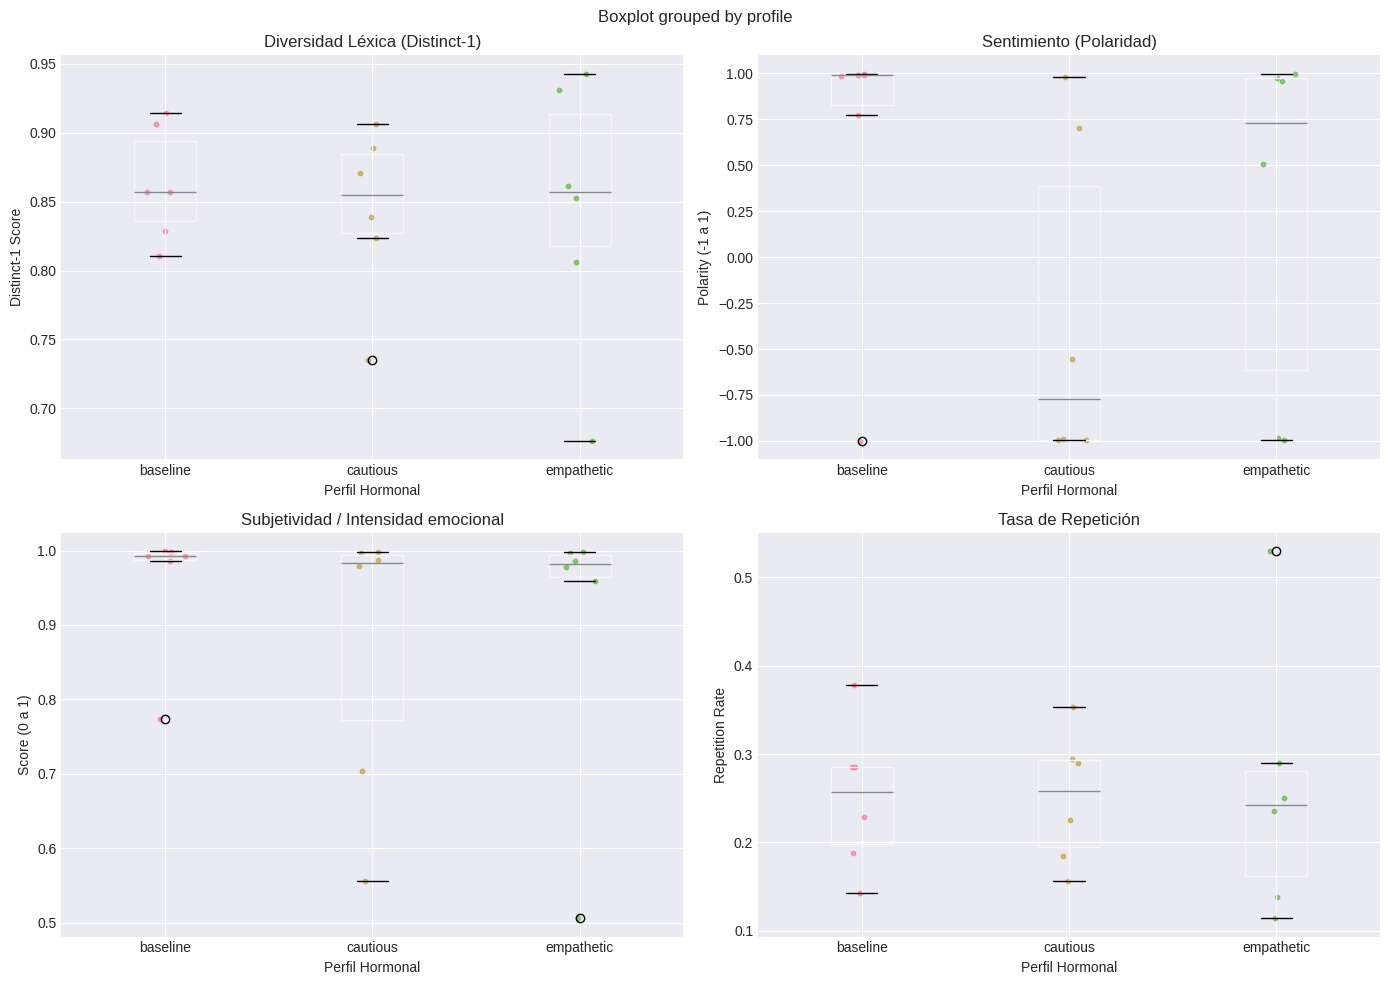

In [ ]:
# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('🧠 Análisis Comparativo: Perfiles Hormonales', fontsize=16, fontweight='bold')

profiles = sorted(metrics_df['profile'].unique())

def add_strip(ax, metric_name):
    """Superpone puntos individuales sobre el boxplot para ver cuántas muestras hay."""
    # Posición base 1..N, asumimos orden alfabético
    x_pos = {profile: i + 1 for i, profile in enumerate(profiles)}
    for profile, group in metrics_df.groupby('profile'):
        x = np.random.normal(loc=x_pos[profile], scale=0.05, size=len(group))
        y = group[metric_name].values
        ax.scatter(x, y, alpha=0.6, s=10)

# 1. Diversidad léxica (Distinct-1)
metrics_df.boxplot(column='distinct_1', by='profile', ax=axes[0, 0])
add_strip(axes[0, 0], 'distinct_1')
axes[0, 0].set_title('Diversidad Léxica (Distinct-1)')
axes[0, 0].set_xlabel('Perfil Hormonal')
axes[0, 0].set_ylabel('Distinct-1 Score')

# 2. Sentimiento (polaridad)
metrics_df.boxplot(column='sentiment_polarity', by='profile', ax=axes[0, 1])
add_strip(axes[0, 1], 'sentiment_polarity')
axes[0, 1].set_title('Sentimiento (Polaridad)')
axes[0, 1].set_xlabel('Perfil Hormonal')
axes[0, 1].set_ylabel('Polarity (-1 a 1)')

# 3. Subjetividad
metrics_df.boxplot(column='sentiment_subjectivity', by='profile', ax=axes[1, 0])
add_strip(axes[1, 0], 'sentiment_subjectivity')
axes[1, 0].set_title('Subjetividad / Intensidad emocional')
axes[1, 0].set_xlabel('Perfil Hormonal')
axes[1, 0].set_ylabel('Score (0 a 1)')

# 4. Tasa de repetición
metrics_df.boxplot(column='repetition_rate', by='profile', ax=axes[1, 1])
add_strip(axes[1, 1], 'repetition_rate')
axes[1, 1].set_title('Tasa de Repetición')
axes[1, 1].set_xlabel('Perfil Hormonal')
axes[1, 1].set_ylabel('Repetition Rate')

plt.tight_layout()
plt.show()


En este conjunto de gráficos se observa, en primer lugar, que la diversidad léxica (Distinct-1) se mantiene alta en los tres perfiles, lo que indica que ninguno de ellos colapsa en respuestas monótonas o de tipo “bucle”. El perfil baseline y el perfil cautious muestran valores muy similares, mientras que el perfil empathetic presenta una diversidad comparable, aunque con algún caso puntual algo más bajo, generalmente asociado a respuestas más cortas. En el eje del sentimiento (polaridad), el perfil baseline tiende a respuestas positivas, el perfil cautious muestra una dispersión mayor entre ejemplos positivos y negativos, y el perfil empathetic concentra la mayoría de sus muestras en la zona claramente positiva, coherente con un nivel elevado de oxitocina que favorece tokens asociados al cuidado y al apoyo. La subjetividad o intensidad emocional permanece alta en casi todos los casos, lo que indica que el modelo genera en general texto de estilo conversacional y cargado de señales emocionales, con ligeras variaciones según el perfil.

En cuanto a la tasa de repetición, los valores se sitúan en un rango moderado para baseline y cautious, reflejando que las respuestas no son puramente repetitivas. En el perfil cautious, el efecto combinado de un cortisol más alto y del mecanismo anti-repetición reduce el riesgo de que el modelo se quede atascado en la misma secuencia de palabras. El perfil empathetic, en cambio, muestra un patrón similar pero con algún ejemplo donde la repetición aumenta, lo que puede interpretarse como una tendencia del modelo a insistir en ciertas fórmulas de consuelo cuando la oxitocina es alta. En conjunto, estos resultados ilustran que los perfiles hormonales modifican de forma sistemática el tono y la dinámica de la generación (sentimiento, repetición), sin destruir la diversidad léxica global, y ofrecen al estudiante un punto de partida para explorar con más detalle cómo pequeños cambios en el vector hormonal afectan al comportamiento del modelo.


## 8. Guardar Resultados

In [ ]:
# Guardar DataFrames
experiment_df.to_csv('experiment_results.csv', index=False)
metrics_df.to_csv('metrics_results.csv', index=False)
profile_stats.to_csv('profile_statistics.csv')

print("💾 Resultados guardados:")
print("  - experiment_results.csv")
print("  - metrics_results.csv")
print("  - profile_statistics.csv")

💾 Resultados guardados:
  - experiment_results.csv
  - metrics_results.csv
  - profile_statistics.csv


## 9. Próximos Pasos

### ✅ Lo que ya funciona:
- Carga del modelo DistilGPT-2
- Vector hormonal y modulación de logits (con temperatura adaptativa, serotonina suavizante y adrenalina con Top-K dinámico)
- Generación con diferentes perfiles
- Métricas básicas automáticas con un clasificador de sentimiento basado en Transformers

### 🚧 Para expandir:

Lo que sigue puede leerse como un pequeño “itinerario” de trabajo sobre el notebook, pensado para ir de lo más simple a lo más ambicioso.

Primero conviene consolidar bien el experimento básico. El punto de partida es ampliar el conjunto de prompts: pasar de unos pocos ejemplos a un conjunto de, al menos, cien o doscientos, guardados en un archivo (CSV o JSON) y organizados en grandes familias: mensajes personales/emocionales, preguntas factuales neutras, textos creativos y frases de conflicto. La tarea inicial del estudiante es simplemente hacer correr el notebook con ese conjunto ampliado, usando siempre los tres perfiles definidos (baseline, cautious, empathetic), y comprobar que los gráficos de métricas (diversidad, polaridad, subjetividad, repetición) muestran tendencias coherentes y reproducibles. En esta fase no hace falta inventar nada nuevo: el objetivo es “llenar de datos” la arquitectura que ya existe y acostumbrarse a leer las gráficas y tablas resultantes.

Cuando esto funcione, el siguiente paso es empezar a aislar efectos. En lugar de trabajar solo con perfiles complejos, se propone fijar todas las hormonas en 0.5 y variar una sola, por ejemplo la adrenalina, de 0.0 a 1.0 en pequeños pasos, repitiendo el experimento y observando cómo cambian las métricas. Después puede hacerse lo mismo con la dopamina, el cortisol, la oxitocina o la serotonina. De este modo el estudiante aprende a vincular cada curva o boxplot con una intuición: “cuando sube adrenalina, baja K y el modelo se vuelve más focalizado”, “si sube cortisol, la temperatura efectiva baja y la repetición tiende a aumentar, compensada por el anti-repetición”, etc. A partir de estas observaciones, se puede ir elaborando el relato de la tesis: qué hace cada hormona y cómo se manifiesta en el comportamiento del modelo.

Por último, cuando la parte básica esté dominada, se pueden explorar ideas más creativas. Una posibilidad es añadir alguna métrica nueva (por ejemplo, perplejidad usando un modelo de referencia, o un clasificador de empatía en lugar de un simple positivo/negativo) y repetir los gráficos con esa información extra. Otra es introducir dinámica: en vez de un vector hormonal fijo, dejar que las hormonas cambien durante la generación (por ejemplo, adrenalina alta al principio que va decayendo) o en función de lo que “dice” el usuario en cada turno. No es necesario implementar todas estas variantes, pero sí elegir una o dos y desarrollarlas con calma, siempre documentando qué se ha cambiado en el código, qué se observa en los resultados y cómo se interpreta desde la metáfora endocrina. De esta manera el notebook pasa de ser una simple demostración a convertirse en el núcleo de una investigación completa y bien argumentada.


1. **Ampliar dataset de prompts**: crear 150-200 prompts balanceados por categoría
2. **Mejorar lexicón empático**: usar NRC Emotion Lexicon completo o embeddings para seleccionar tokens cercanos a "care", "support", etc.
3. **Métricas avanzadas**:
   - Perplexity
   - Self-BLEU
   - Clasificadores específicos de empatía (RoBERTa-empathy, etc.)
4. **Experimentos sistemáticos**:
   - Fase 1: Efectos individuales (cada hormona alta)
   - Fase 2: Perfiles bio-inspirados completos
   - Fase 3: Interacciones (conflictos hormonales)
5. **Evaluación humana**: preparar interfaz para anotación (por ejemplo, encuestas donde evaluadores puntúan empatía, claridad, utilidad).
6. **Análisis estadístico**: ANOVA, tests post-hoc, correlaciones entre niveles hormonales y métricas.
7. **Probar otros LLM**: modelos más pequeños o más grandes para ver si las tendencias se mantienen.

Este notebook puede verse como un **“banco de pruebas endocrino”**:
un código base desde el cual el estudiante puede:
- Definir nuevos perfiles hormonales,
- Ajustar los pesos α, β, γ, δ, ε,
- Añadir métricas y prompts específicos del dominio de aplicación (p. ej. diálogo clínico, tutoría, etc.),
y documentar rigurosamente cómo cambian los comportamientos del modelo.

Como líneas de trabajo futuro, este prototipo abre varias posibilidades: por un lado, refinar el mapeo entre hormonas y operaciones sobre los logits (explorando otras funciones de temperatura adaptativa, estrategias de Top-K dinámico o sesgos semánticos más ricos basados en embeddings), ampliar el conjunto de prompts y dominios de prueba, e incorporar evaluaciones humanas sistemáticas que complementen las métricas automáticas. Por otro lado, la misma arquitectura de modulación endocrina puede trasladarse casi sin cambios a modelos de lenguaje de pesos abiertos más potentes (por ejemplo, Llama o Mistral de 7–8B parámetros) siempre que se carguen localmente mediante AutoModelForCausalLM, por ejemplo en una GPU de Google Colab o con cuantización ligera. Esto permitiría estudiar si los efectos observados se mantienen o se amplifican al incrementar la capacidad del modelo, y comparar de forma rigurosa el compromiso entre complejidad computacional, control fino mediante “hormonas” y calidad percibida de las respuestas




### Glosario de términos

**Prompt**
Texto de entrada que se da al modelo para que genere una continuación. En los experimentos se usan muchos prompts distintos para probar cómo responden los diferentes perfiles hormonales.

**Perfil hormonal**
Configuración concreta de los valores de dopamina, cortisol, oxitocina, adrenalina y serotonina (por ejemplo, `baseline`, `cautious`, `empathetic`). Cada perfil produce un estilo de respuesta diferente al modificar la distribución de probabilidades del modelo.

**Logits**
Valores numéricos que el modelo produce antes de aplicar la función softmax. Cada logit corresponde a un token del vocabulario. Al modificar estos valores (por ejemplo, con el procesador hormonal) se cambia indirectamente la probabilidad de cada token.

**Temperatura**
Parámetro que controla cuánto explora el modelo. Una temperatura alta “aplasta” las diferencias entre logits y hace la distribución más plana (más exploración, más creatividad). Una temperatura baja resalta aún más los tokens con mayor probabilidad (respuestas más predecibles).

**Top-K**
Técnica de muestreo en la que, en cada paso de generación, solo se consideran los K tokens con logits más altos y el resto se descartan. En este notebook, la adrenalina controla un Top-K dinámico: a mayor adrenalina, menor K y, por tanto, una “visión de túnel” más marcada.

**Dopamina**
Hormona asociada a exploración y recompensa. En el modelo, niveles altos de dopamina aumentan la temperatura adaptativa y fomentan la exploración de continuaciones menos obvias.

**Cortisol**
Hormona asociada al estrés y la cautela. En el modelo, niveles altos de cortisol reducen la temperatura adaptativa, centran la distribución en pocos tokens muy probables y activan mecanismos anti-repetición para evitar bucles.

**Oxitocina**
Hormona vinculada a la prosocialidad y el apego. Aquí se implementa como un sesgo positivo hacia tokens considerados “empáticos” (por ejemplo, *understand*, *help*, *support*), aumentando la probabilidad de que aparezcan en las respuestas.

**Adrenalina**
Hormona asociada a la activación y la respuesta de emergencia. En este trabajo se traduce en un Top-K dinámico: cuando la adrenalina supera un umbral, el modelo solo considera un subconjunto pequeño de tokens de alta probabilidad, concentrando la respuesta.

**Serotonina**
Hormona relacionada con la estabilidad del estado de ánimo. En el modelo actúa suavizando los extremos de los logits: reduce la diferencia entre los tokens más y menos probables y hace la distribución más estable, evitando cambios bruscos.

**Diversidad léxica (Distinct-1 / Distinct-2)**
Medidas que indican cuánto vocabulario distinto se usa. Distinct-1 se basa en palabras individuales, Distinct-2 en pares de palabras consecutivas (bigramas). Valores altos indican textos variados; valores muy bajos pueden señalar repetición excesiva.

**Polaridad del sentimiento**
Medida numérica que indica si el texto es percibido como globalmente negativo (cerca de -1) o positivo (cerca de +1) por el modelo de análisis de sentimiento.

**Subjetividad / intensidad emocional**
Medida que indica cuánta carga emocional detecta el clasificador en el texto. Valores altos suelen asociarse a opiniones, emociones o juicios; valores bajos, a texto más neutro o factual.

**Tasa de repetición (repetition rate)**
Proporción de palabras que aparecen más de una vez dentro de la misma respuesta. Una tasa alta puede indicar falta de diversidad o aparición de patrones repetitivos no deseados.

**Perplejidad (Perplexity, PPL)**
Métrica clásica para evaluar modelos de lenguaje. Cuanto más baja es la perplejidad, mejor “predice” el modelo las palabras del texto. En este contexto se puede usar un modelo de referencia, sin modulación hormonal, para comprobar si las modificaciones endocrinas mantienen una calidad lingüística razonable.
